<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# 5. Fishing for Correlations at Sea
Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are four considerations:

1. __Persistence__, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel).
1. __Time irregularities__, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
1. __Age uncertainties__, for example comparing two records, each with an ensemble of plausible chronologies (generated, for instance, by a Bayesian age model)
1. __Test multiplicity__ aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

Accordingly,  Pyleoclim facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results. We start by loading a few useful packages:

In [1]:
import matplotlib.pyplot as plt    
import pyleoclim as pyleo
pyleo.set_style('web')  # set the visual style
import numpy as np
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

## A case study from Crystal Cave
In this notebook we reproduce the case of [Hu et al, 2017](http://dx.doi.org/10.1016/j.epsl.2016.11.048), particularly the example of their section 4, which illustrates several of these pitfalls at once. The example illuminates the issue of relying too strongly on correlations between a paleoclimate record and an instrumental field to interpret the record. Before we start, a disclaimer: the studies investigated in this paper are by no means isolated cases. They just happened to be cases that we knew about, and thought deserved a second look in light of more rigorous statistics. The same study could have been written by subsituting any number of other records interpreted, wholly or in part, on the basis of correlations. Accordingly, what follows should not be viewed as an indictment of a particularly study or group of authors, rather, at how easy it is by the best-intentioned scientists to get fooled by spurious correlations, and (thankfully), how easy we've made it not get similarly fooled by carrying out this analysis with `pyleoclim`. 


### The Crystal Cave record

The example uses the speleothem record of [McCabe-Glynn et al , 2013](https://www.nature.com/articles/ngeo1862) from Crystal Cave, California, in the Sequoia National Forest.  Of interest to us is the $\delta^{18}O$ record, which the authors interepret as reflecting sea-surface temperatures (SST) in the Kuroshio Extension region of the West Pacific. This is a strong claim, given that no mechanistic link is proposed,  and relies entirely on an analysis of correlations between the record and instrumental SST.  

We first load and plot this record:

In [2]:
d = pyleo.Lipd('../data/Crystal.McCabe-Glynn.2013.lpd')
cc = d.to_LipdSeries(2)   

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting paleoData...
extracting: Crystal.McCabe-Glynn.2013
Created time series: 3 entries


Let's do a quick plot to check that we have what we want:

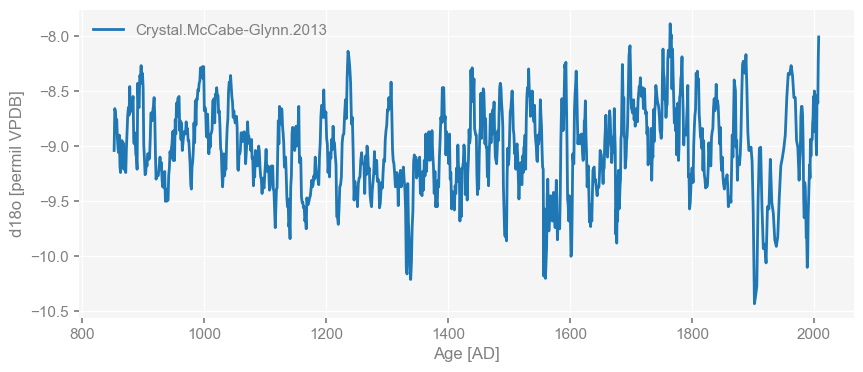

In [5]:
fig, ax = cc.plot(mute=True)
pyleo.showfig(fig, close=True)

Notice how the code harvested the correct metadata from the LiPD file. If everything is in its right place, it makes it easy to exploit that information. If you're feeling more frisky, you can even ask for a whole dashboard, including a spectrum:

Performing spectral analysis on individual series: 100%|█| 200/200 [00:34<00:00,


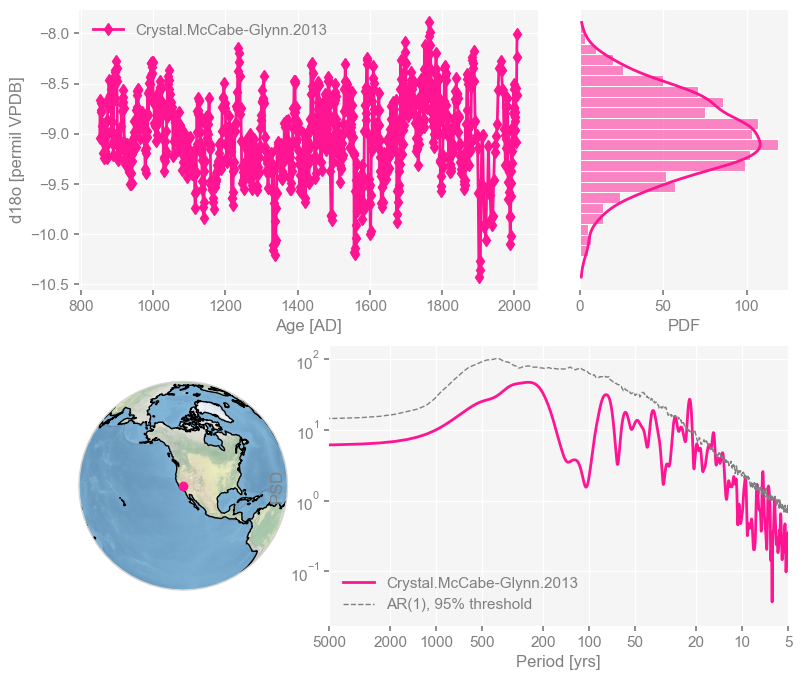

(<Figure size 1100x800 with 4 Axes>,
 {'ts': <AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>,
  'dts': <AxesSubplot:xlabel='PDF'>,
  'map': <GeoAxesSubplot:>,
  'spec': <AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>})

In [4]:
cc.dashboard(metadata=False)

This is a very high resolution record, with near-annual spacing (check it), and a broadly red spectrum that exhibits a number of spectral peaks at interannual and decadal scales.


### SST data

The original paper correlated the above record against the Kaplan SST dataset.  In this notebook we instead use the [HadSST4 dataset](https://www.metoffice.gov.uk/hadobs/hadsst4/index.html),  which is more up to date, and which we first download via `wget`. (~8Mb)

In [6]:
!wget https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc

--2021-10-19 15:37:08--  https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 104.117.118.23
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|104.117.118.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8725191 (8.3M) [application/x-netcdf]
Saving to: ‘HadSST.4.0.1.0_median.nc’

HadSST.4.0.1.0_medi 100%[===================>]   8.32M  13.9MB/s    in 0.6s    

2021-10-19 15:37:10 (13.9 MB/s) - ‘HadSST.4.0.1.0_median.nc’ saved [8725191/8725191]



Next we load it via the excellent `xarray` package.

In [6]:
ds = xr.open_dataset('HadSST.4.0.1.0_median.nc')
print(ds)

<xarray.Dataset>
Dimensions:         (time: 2060, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2021-08-16T...
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7


As an example, let's only consider the Northern Hemisphere Pacific Ocean. For practicality, let's first adjust the coordinate system so that longitude is expressed from 0 to 360 degrees instead of 180W to 180E:

In [7]:
ds_rolled = ds.assign_coords(longitude=(ds.longitude % 360)).roll(longitude=(ds.dims['longitude'] // 2))
ds_rolled

/var/folders/xj/p7h9764x7cx0by8547l04rrr0000gn/T/ipykernel_8090/4012817607.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_rolled = ds.assign_coords(longitude=(ds.longitude % 360)).roll(longitude=(ds.dims['longitude'] // 2))


<xarray.Dataset>
Dimensions:         (time: 2060, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2021-08-16T...
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan nan nan ... nan nan
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 0.0 5.0 5.0 10.0 ... -5.0 -5.0 0.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

Now let's select the needed data:

In [8]:
ds_sel = ds_rolled.sel(longitude=slice(120,280),latitude=slice(0,90))
ds_sel

<xarray.Dataset>
Dimensions:         (time: 2060, latitude: 18, longitude: 32, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2021-08-16T...
  * latitude        (latitude) float64 2.5 7.5 12.5 17.5 ... 72.5 77.5 82.5 87.5
  * longitude       (longitude) float64 122.5 127.5 132.5 ... 267.5 272.5 277.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan -0.1923 ... nan nan
    time_bnds       (time, bnds) datetime64[ns] 1850-01-01 ... 2021-09-01
    latitude_bnds   (latitude, bnds) float64 0.0 5.0 5.0 10.0 ... 85.0 85.0 90.0
    longitude_bnds  (longitude, bnds) float64 120.0 125.0 125.0 ... -85.0 -80.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

## Pitfall #1: Persistence

Persistence is the tendency of many geophysical timeseries (particularly in paleoclimatology) to show some kind of memory: consecutive observations tend to resemble each other, resulting in timeseries that have fairly broad trends and low-frequency fluctuations, and comparatively little high-frequency fluctuations. 

This has an important consequence: the standard assumption of independence, which undergirds much of frequentist statistics, is violated in this case. In a timeseries with $n$ fully independent observations (e.g. white noise), the degrees of freedom for the variance are $DOF = n -1$  But if memory is present, this number can be drastically reduced. 

### Single location
Let us look at a random location and build some intuition. First, we need to compute montly anomalies and annualize them. `xarray` makes that easy (4 lines of code), so let's look at the result:

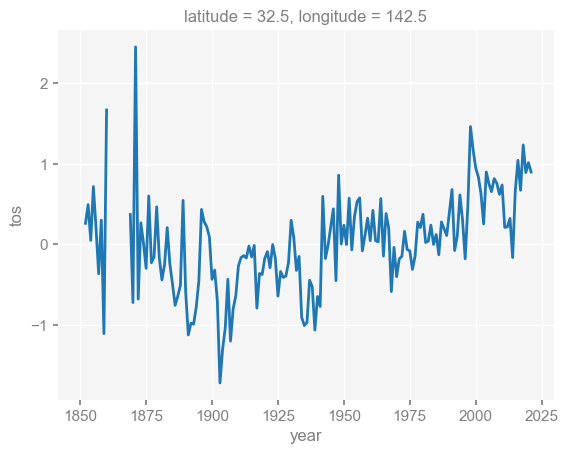

In [9]:
st = ds['tos'].sel(latitude=32.5, longitude = 142.5, method='nearest')  # 32.5N 142.5W near Kuroshio Extension
climatology = st.groupby("time.month").mean("time")
anomalies = st.groupby("time.month") - climatology
st_annual = anomalies.groupby("time.year").mean("time")
f, ax = plt.subplots()
st_annual.plot()
pyleo.showfig(f)

Notice the coverage gaps in the 1860s. This, and the fact that the Crystal Cave chronology is not uniformly spaced, would ordinarily make it challenging (at the vary least, bothersome) to compare the two series, requiring some form of interpolation or binning. Pyleoclim does all this for you under the hood.

To enjoy these benefits, however, let us turn the temperature data into a _Series_ object.

In [10]:
stts = pyleo.Series(time=st_annual.coords['year'].values,
                    time_unit ='year CE', 
                    value=st_annual.values,
                    value_unit = 'C')

Now we can compute correlations with the Crystal Cave record. 

In [10]:
corr_res = stts.correlation(cc)
print(corr_res.r)

0.3174614187627409


Quite a few things happened here. First, `pyleoclim` was smart enough to figure out a common timespan between the two records, and used linear interpolation to align the two timeseries on a common axis. 

The resulting correlation is $r=0.32$. Is it significant?

The standard way to assess this (embedded in countless computing packages), is with a t-test using the test statistic: $$T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$

If we plug the numbers in, we get the following:  

In [11]:
ccs = cc.slice([1854,2020])
n = len(ccs.time)
nu = n-2
r = corr_res.r
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 3.511193304901331


Under standard assumptions (the data are independent and identically distributed), $T$ follows Student's $t$ distribution (the first [Guiness-soaked distribution](https://priceonomics.com/the-guinness-brewer-who-revolutionized-statistics/) in history). If we make the same assumption and use the $t$ distribution conveniently programmed for us by SciPy, we can compute the p-value (the probability to observe a test statistic at least as large as this one, under this distribution) thusly:

In [12]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is "+ str(pval))

The p-value is 0.0003240082098138197


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that SST at 42N, 142E shares so much similarity with the Crystal Cave record that there are only a few chances in 10,000 that this could have happened randomly. In other words, it looks _rather_ significant. 

But let's take a step back. That test (which is the one that most computing packages, including Excel, will do for you out of the box), is completely inappropriate here. Why? Because it tramples over the concept of persistence with gleeful impunity. That is, it assumes that consecutive observations bear no resemblance to each other, which is true neither of the Crystal Cave nor the instrumental target. That is to say: because temperature in one year tends to resemble temperature in the previous or following year (same for $\delta^{18}O$, the data are anything but independent. 

Going back to the result of the `correlation()` command, let's look at its full output:

In [13]:
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.317461       0.12  False



Notice that the p-value has been estimated to be 12% (`'p': 0.12`), and therefore the correlation is not deemed significant (`'signif': False`) at the 5% level (`'alpha': 0.05`).

How did `pyleoclim` arrive at such a different conclusion? By not applying irrelevant assumptions, of course! To know what method was applied exactly precisely, consult the [documentation](https://pyleoclim-util.readthedocs.io/en/stable/index.html) or the docstring. 

**Exercise 5.1** What method does `correlation` use by default to assess significance and what are its assumptions? (hint: check out "correlation" on [Read The Docs](https://pyleoclim-util.readthedocs.io/en/stable/index.html), under "The Pyleoclim user interface"), or type `stts.correlation?` at the prompt.

**Answer 5.1** YOUR WORDS HERE



**Exercise 5.2** There are in fact 3 ways to make this determination in Pyleoclim. Try the other two in the cells below, and compare their p-values. Do they give consistent answers or not?

In [ ]:
## your code here ##

## Pitfall #2: Multiple testing

The foregoing shows how to properly assess significance at just one location. How would we go about conducting a similar test for an entire field? Let us first try the naive approach: recursively carry out the same test as above at all grid points.  For this, we need not only to loop over grid points, but also store the p-values for later analysis. To save time, we'll use the `ttest` option for `correlation()`, knowing that it is rather approximate. Also, we need to exclude points that have too few observations.  The loop below achieves that. 

In [11]:
nlon = len(ds_sel['longitude'])
nlat = len(ds_sel['latitude']) 
pval = np.empty((nlon,nlat)) # declare array to store pvalues
corr = np.empty_like(pval) # declare empty array of identical shape
alpha = 0.05
slon, slat = [], [];
for ji in range(nlon):
    for jj in range(nlat):     # TODO add progress bar 
        st = ds_sel['tos'][:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        st_annual = anomalies.groupby("time.year").mean("time")
        #  test if at least 100 non-NaNs
        noNaNs = len(np.where(np.isnan(st_annual) == False)[0]) # number of valid years
        sstvar = st_annual.var()
        if noNaNs >= 100 and sstvar >= 0.01:
            print("Computing correlation at " + str(ds_sel.latitude[jj].values) + 'N, ' + str(ds_sel.longitude[ji].values) + 'E')
            sttb = pyleo.Series(time=st_annual.coords['year'].values,
                        time_unit ='year CE', 
                        value=st_annual.values,
                        value_unit = 'C')
            corr_res = sttb.correlation(cc, settings={'method':'ttest'})
            pval[ji,jj] = corr_res.p
            corr[ji,jj] = corr_res.r
            if pval[ji,jj] < alpha:
                slon.append(ds_sel.longitude[ji])
                slat.append(ds_sel.latitude[jj])
        else:  
            pval[ji,jj] = np.nan; corr[ji,jj] = np.nan

Computing correlation at 2.5N, 122.5E
Computing correlation at 7.5N, 122.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 12.5N, 122.5E
Computing correlation at 17.5N, 122.5E
Computing correlation at 22.5N, 122.5E
Computing correlation at 27.5N, 122.5E
Computing correlation at 32.5N, 122.5E
Computing correlation at 37.5N, 122.5E
Computing correlation at 42.5N, 122.5E
Computing correlation at 2.5N, 127.5E
Computing correlation at 7.5N, 127.5E
Computing correlation at 12.5N, 127.5E
Computing correlation at 17.5N, 127.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 22.5N, 127.5E
Computing correlation at 27.5N, 127.5E
Computing correlation at 32.5N, 127.5E
Computing correlation at 37.5N, 127.5E
Computing correlation at 42.5N, 127.5E
Computing correlation at 2.5N, 132.5E
Computing correlation at 7.5N, 132.5E
Computing correlation at 12.5N, 132.5E
Computing correlation at 17.5N, 132.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 22.5N, 132.5E
Computing correlation at 27.5N, 132.5E
Computing correlation at 32.5N, 132.5E
Computing correlation at 37.5N, 132.5E
Computing correlation at 42.5N, 132.5E
Computing correlation at 2.5N, 137.5E
Computing correlation at 7.5N, 137.5E
Computing correlation at 12.5N, 137.5E
Computing correlation at 17.5N, 137.5E
Computing correlation at 22.5N, 137.5E
Computing correlation at 27.5N, 137.5E
Computing correlation at 32.5N, 137.5E
Computing correlation at 37.5N, 137.5E
Computing correlation at 42.5N, 137.5E
Computing correlation at 47.5N, 137.5E
Computing correlation at 2.5N, 142.5E
Computing correlation at 7.5N, 142.5E
Computing correlation at 12.5N, 142.5E
Computing correlation at 17.5N, 142.5E
Computing correlation at 22.5N, 142.5E
Computing correlation at 27.5N, 142.5E
Computing correlation at 32.5N, 142.5E
Computing correlation at 37.5N, 142.5E
Computing correlation at 42.5N, 142.5E
Computing correlation at 47.5N, 142.5E
Computing correlation at 52.5

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 42.5N, 152.5E
Computing correlation at 47.5N, 152.5E
Computing correlation at 52.5N, 152.5E
Computing correlation at 2.5N, 157.5E
Computing correlation at 7.5N, 157.5E
Computing correlation at 12.5N, 157.5E
Computing correlation at 17.5N, 157.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 22.5N, 157.5E
Computing correlation at 27.5N, 157.5E
Computing correlation at 32.5N, 157.5E
Computing correlation at 37.5N, 157.5E
Computing correlation at 42.5N, 157.5E
Computing correlation at 47.5N, 157.5E
Computing correlation at 52.5N, 157.5E
Computing correlation at 2.5N, 162.5E
Computing correlation at 7.5N, 162.5E
Computing correlation at 12.5N, 162.5E
Computing correlation at 17.5N, 162.5E
Computing correlation at 22.5N, 162.5E
Computing correlation at 27.5N, 162.5E
Computing correlation at 32.5N, 162.5E
Computing correlation at 37.5N, 162.5E
Computing correlation at 42.5N, 162.5E
Computing correlation at 47.5N, 162.5E
Computing correlation at 52.5N, 162.5E
Computing correlation at 57.5N, 162.5E
Computing correlation at 2.5N, 167.5E
Computing correlation at 7.5N, 167.5E
Computing correlation at 12.5N, 167.5E
Computing correlation at 17.5N, 167.5E
Computing correlation at 22.5N, 167.5E
Computing correlation at 27.5N, 167.5E
Computing correlation at 32.5

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 57.5N, 172.5E
Computing correlation at 62.5N, 172.5E
Computing correlation at 2.5N, 177.5E
Computing correlation at 7.5N, 177.5E
Computing correlation at 12.5N, 177.5E
Computing correlation at 17.5N, 177.5E
Computing correlation at 22.5N, 177.5E
Computing correlation at 27.5N, 177.5E
Computing correlation at 32.5N, 177.5E
Computing correlation at 37.5N, 177.5E
Computing correlation at 42.5N, 177.5E
Computing correlation at 47.5N, 177.5E
Computing correlation at 52.5N, 177.5E
Computing correlation at 57.5N, 177.5E
Computing correlation at 62.5N, 177.5E
Computing correlation at 2.5N, 182.5E
Computing correlation at 7.5N, 182.5E
Computing correlation at 12.5N, 182.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 17.5N, 182.5E
Computing correlation at 22.5N, 182.5E
Computing correlation at 27.5N, 182.5E
Computing correlation at 32.5N, 182.5E
Computing correlation at 37.5N, 182.5E
Computing correlation at 42.5N, 182.5E
Computing correlation at 47.5N, 182.5E
Computing correlation at 52.5N, 182.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 57.5N, 182.5E
Computing correlation at 2.5N, 187.5E
Computing correlation at 7.5N, 187.5E
Computing correlation at 12.5N, 187.5E
Computing correlation at 17.5N, 187.5E
Computing correlation at 22.5N, 187.5E
Computing correlation at 27.5N, 187.5E
Computing correlation at 32.5N, 187.5E
Computing correlation at 37.5N, 187.5E
Computing correlation at 42.5N, 187.5E
Computing correlation at 47.5N, 187.5E
Computing correlation at 52.5N, 187.5E
Computing correlation at 57.5N, 187.5E
Computing correlation at 62.5N, 187.5E
Computing correlation at 2.5N, 192.5E
Computing correlation at 7.5N, 192.5E
Computing correlation at 12.5N, 192.5E
Computing correlation at 17.5N, 192.5E
Computing correlation at 22.5N, 192.5E
Computing correlation at 27.5N, 192.5E
Computing correlation at 32.5N, 192.5E
Computing correlation at 37.5N, 192.5E
Computing correlation at 42.5N, 192.5E
Computing correlation at 47.5N, 192.5E
Computing correlation at 52.5N, 192.5E
Computing correlation at 57.5

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 67.5N, 192.5E
Computing correlation at 2.5N, 197.5E
Computing correlation at 7.5N, 197.5E
Computing correlation at 12.5N, 197.5E
Computing correlation at 17.5N, 197.5E
Computing correlation at 22.5N, 197.5E
Computing correlation at 27.5N, 197.5E
Computing correlation at 32.5N, 197.5E
Computing correlation at 37.5N, 197.5E
Computing correlation at 42.5N, 197.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 47.5N, 197.5E
Computing correlation at 52.5N, 197.5E
Computing correlation at 57.5N, 197.5E
Computing correlation at 67.5N, 197.5E
Computing correlation at 72.5N, 197.5E
Computing correlation at 2.5N, 202.5E
Computing correlation at 7.5N, 202.5E
Computing correlation at 12.5N, 202.5E
Computing correlation at 17.5N, 202.5E
Computing correlation at 22.5N, 202.5E
Computing correlation at 27.5N, 202.5E
Computing correlation at 32.5N, 202.5E
Computing correlation at 37.5N, 202.5E
Computing correlation at 42.5N, 202.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 47.5N, 202.5E
Computing correlation at 52.5N, 202.5E
Computing correlation at 57.5N, 202.5E
Computing correlation at 2.5N, 207.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 7.5N, 207.5E
Computing correlation at 12.5N, 207.5E
Computing correlation at 17.5N, 207.5E
Computing correlation at 22.5N, 207.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 27.5N, 207.5E
Computing correlation at 32.5N, 207.5E
Computing correlation at 37.5N, 207.5E
Computing correlation at 42.5N, 207.5E
Computing correlation at 47.5N, 207.5E
Computing correlation at 52.5N, 207.5E
Computing correlation at 57.5N, 207.5E
Computing correlation at 2.5N, 212.5E
Computing correlation at 7.5N, 212.5E
Computing correlation at 12.5N, 212.5E
Computing correlation at 17.5N, 212.5E
Computing correlation at 22.5N, 212.5E
Computing correlation at 27.5N, 212.5E
Computing correlation at 32.5N, 212.5E
Computing correlation at 37.5N, 212.5E
Computing correlation at 42.5N, 212.5E
Computing correlation at 47.5N, 212.5E
Computing correlation at 52.5N, 212.5E
Computing correlation at 57.5N, 212.5E
Computing correlation at 62.5N, 212.5E
Computing correlation at 2.5N, 217.5E
Computing correlation at 7.5N, 217.5E
Computing correlation at 12.5N, 217.5E
Computing correlation at 17.5N, 217.5E
Computing correlation at 22.5N, 217.5E
Computing correlation at 27.5

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 37.5N, 217.5E
Computing correlation at 42.5N, 217.5E
Computing correlation at 47.5N, 217.5E
Computing correlation at 52.5N, 217.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 57.5N, 217.5E
Computing correlation at 2.5N, 222.5E
Computing correlation at 7.5N, 222.5E
Computing correlation at 12.5N, 222.5E
Computing correlation at 17.5N, 222.5E
Computing correlation at 22.5N, 222.5E
Computing correlation at 27.5N, 222.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 32.5N, 222.5E
Computing correlation at 37.5N, 222.5E
Computing correlation at 42.5N, 222.5E
Computing correlation at 47.5N, 222.5E
Computing correlation at 52.5N, 222.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 57.5N, 222.5E
Computing correlation at 2.5N, 227.5E
Computing correlation at 7.5N, 227.5E
Computing correlation at 12.5N, 227.5E
Computing correlation at 17.5N, 227.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 22.5N, 227.5E
Computing correlation at 27.5N, 227.5E
Computing correlation at 32.5N, 227.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 37.5N, 227.5E
Computing correlation at 42.5N, 227.5E
Computing correlation at 47.5N, 227.5E
Computing correlation at 52.5N, 227.5E
Computing correlation at 57.5N, 227.5E
Computing correlation at 2.5N, 232.5E
Computing correlation at 7.5N, 232.5E
Computing correlation at 12.5N, 232.5E
Computing correlation at 17.5N, 232.5E
Computing correlation at 22.5N, 232.5E
Computing correlation at 27.5N, 232.5E
Computing correlation at 32.5N, 232.5E
Computing correlation at 37.5N, 232.5E
Computing correlation at 42.5N, 232.5E
Computing correlation at 47.5N, 232.5E
Computing correlation at 52.5N, 232.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 2.5N, 237.5E
Computing correlation at 7.5N, 237.5E
Computing correlation at 12.5N, 237.5E
Computing correlation at 17.5N, 237.5E
Computing correlation at 22.5N, 237.5E
Computing correlation at 27.5N, 237.5E
Computing correlation at 32.5N, 237.5E
Computing correlation at 37.5N, 237.5E
Computing correlation at 42.5N, 237.5E
Computing correlation at 47.5N, 237.5E
Computing correlation at 2.5N, 242.5E
Computing correlation at 7.5N, 242.5E
Computing correlation at 12.5N, 242.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 17.5N, 242.5E
Computing correlation at 22.5N, 242.5E
Computing correlation at 27.5N, 242.5E
Computing correlation at 32.5N, 242.5E
Computing correlation at 2.5N, 247.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 7.5N, 247.5E
Computing correlation at 12.5N, 247.5E
Computing correlation at 17.5N, 247.5E
Computing correlation at 22.5N, 247.5E
Computing correlation at 27.5N, 247.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 2.5N, 252.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 7.5N, 252.5E
Computing correlation at 12.5N, 252.5E
Computing correlation at 17.5N, 252.5E
Computing correlation at 22.5N, 252.5E
Computing correlation at 27.5N, 252.5E
Computing correlation at 2.5N, 257.5E
Computing correlation at 7.5N, 257.5E
Computing correlation at 12.5N, 257.5E
Computing correlation at 17.5N, 257.5E
Computing correlation at 2.5N, 262.5E
Computing correlation at 7.5N, 262.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 12.5N, 262.5E
Computing correlation at 17.5N, 262.5E
Computing correlation at 22.5N, 262.5E
Computing correlation at 27.5N, 262.5E
Computing correlation at 2.5N, 267.5E
Computing correlation at 7.5N, 267.5E
Computing correlation at 12.5N, 267.5E
Computing correlation at 17.5N, 267.5E
Computing correlation at 22.5N, 267.5E
Computing correlation at 27.5N, 267.5E
Computing correlation at 2.5N, 272.5E
Computing correlation at 7.5N, 272.5E


/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Computing correlation at 12.5N, 272.5E
Computing correlation at 17.5N, 272.5E
Computing correlation at 22.5N, 272.5E
Computing correlation at 27.5N, 272.5E
Computing correlation at 32.5N, 272.5E
Computing correlation at 2.5N, 277.5E
Computing correlation at 7.5N, 277.5E
Computing correlation at 12.5N, 277.5E
Computing correlation at 17.5N, 277.5E
Computing correlation at 22.5N, 277.5E
Computing correlation at 27.5N, 277.5E
Computing correlation at 32.5N, 277.5E


In [15]:
pvals = pval.flatten()
pvec = pvals[pvals<1] # restrict to valid probabilities as there are a few weird values.
nt = len(pvec)
print(nt)

327


In [16]:
slon = np.array(slon)
if np.min(slon) < 0:
        slon = np.mod(slon, 360)
slat = np.array(slat)
len(np.where(pvec<0.05)[0])

23

We found 327 with enough data for a meaningful comparison, and 23 locations that pass the test. Where are they? To gain insight, let us plot the correlations and indicate (by shading) which are deemed significant:

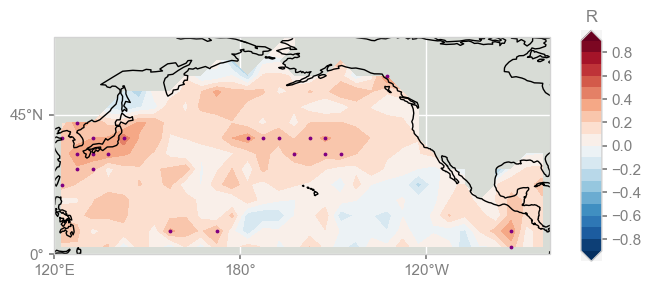

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['light grey']

fig = plt.figure(figsize=[8, 6])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))

# map
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()

transform = ccrs.PlateCarree()
latlon_range = (120, 280, 0, 70)
lon_min, lon_max, lat_min, lat_max = latlon_range
lon_ticks = [60, 120, 180, 240, 300]
lat_ticks = [-90, -45, 0, 45, 90]

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=transform)
ax.set_yticks(lat_ticks[mask_lat], crs=transform)

# contour
clevs = np.linspace(-0.9, 0.9, 19)
#corr_r, lon_r = rotate_lon(corr.T, lon)  # rotate the field to make longitude in increasing order and convert to range (0, 360)
im = ax.contourf(ds_sel.longitude, ds_sel.latitude, corr.T, clevs, transform=transform, cmap='RdBu_r', extend='both')

# significant points
plt.scatter(x=slon, y=slat, color="purple", s=3,
            alpha=1,
            transform=transform) 


# colorbar
cbar_pad = 0.05
cbar_orientation = 'vertical'
cbar_aspect = 10
cbar_fraction = 0.15
cbar_shrink = 0.5
cbar_title = 'R'
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
                    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title(cbar_title)

pyleo.showfig(fig)

The purple dots on the map are the locations of the gridpoints where the p-values fall under 5%, and they naturally correspond to the regions of highest correlations, though (and this is suspicious) they are rather randomly scattered across the domain.  
We might be tempted to declare victory and hail them as "significant", but not so fast! 
Our correlation test, nifty though it is, isn't infallible. In fact, conducting tests at the 5% level (equivalently, the 95% confidence level) specifically means that we expect 5% of our tests to return spurious results, just from chance alone. We just carried out $n_t$ tests, so we expect $0.05*n_t \approx 16 $ of those results to be bunk, right out of the gate.  Which ones can we trust?

Let us rank order the p-values of all 327 tests and plot them as in Hu et al (2017), Fig 2.

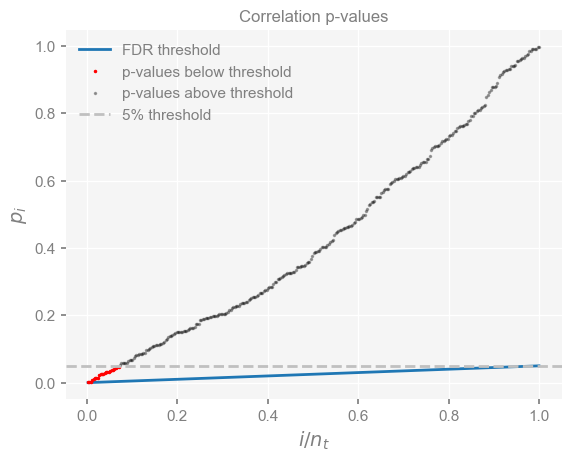

In [18]:
#check i/m vs. p-values
indexm = np.arange(1,nt+1,1)
im = 1.0*indexm / nt
thres = 0.05*im
pvec_s = sorted(pvec)
smaller=[]
small_index=[]
larger=[]
large_index=[]

n=0
for pp in pvec_s:
    if pp <=0.05:
        smaller.append(pp)
        small_index.append(im[n])
    else:
        larger.append(pp)
        large_index.append(im[n])
    n=n+1

f, ax = plt.subplots()
#plt.plot(im,pvec_s,'kx',markersize=1.5,label='p-values',alpha=0.3)
plt.plot(im,thres,label='FDR threshold')
plt.plot(small_index,smaller,'ro',markersize=1.5,label='p-values below threshold')
plt.plot(large_index,larger,'ko',markersize=1.5,label='p-values above threshold',alpha=0.3)
plt.axhline(y=0.05,linestyle='dashed',color='silver',label='5% threshold')
plt.xlabel(r'$i/n_t$',fontsize=14)
plt.ylabel(r'$p_i$',fontsize=14)
plt.title('Correlation p-values')
plt.legend()
#plt.tick_params(labelsize=14)
pyleo.showfig(f)

One solution to this is the False Discovery Rate (aka **FDR**), was devised in a celebrated 1995 paper [(Benjamini & Hochberg, 1995)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x). The idea is to look not just for the p-values under 5% (red dots in the figure above), but for the fraction of those under the blue line, which guards against the false discoveries one expects out of repeatedly testing the same hypothesis over and over again. Luckily for you, we have this coded up in `pyleoclim` (you knew we would). One way to access it is thus:

In [19]:
fdr_res = pyleo.utils.correlation.fdr(pvec_s)
print(fdr_res)

None


And with this treatment, exactly 0 gridpoints pass the test. 

**Exercise 5.3** redo this with other correlation methods and see if the results change. A little patience is required for the other two methods, which loop over surrogates. We suggest using a moderate number of simulations (`nsim` < 500) to do so; please check the documentation of `corr_sig` for how to reduce this number, which is 1000 by default.


## Pitfall #3: Age uncertainties

As if the first two pitfalls weren't enough, there is a third difficulty in this comparison: beautiful though U/Th chronologies may be, they are not perfect (do not believe people who tell you otherwise!). Such chronological uncertainties must be taken into account as well. 

It turns out that the LiPD file loaded above contains not only the raw U/Th dates (dig for them if you're curious), but also an ensemble of age-depth relationships derived from those dates, via the Bayesian age model [BChron](https://cran.r-project.org/web/packages/Bchron/vignettes/Bchron.html). Let us load those 1000 draws from the posterior distribution of ages and put them in a place where `pyleoclim` will be able to work with them:

In [20]:
cc_ens = cc.chronEnsembleToPaleo(d)

There are two ways to plot this ensemble. First, as a series of traces:

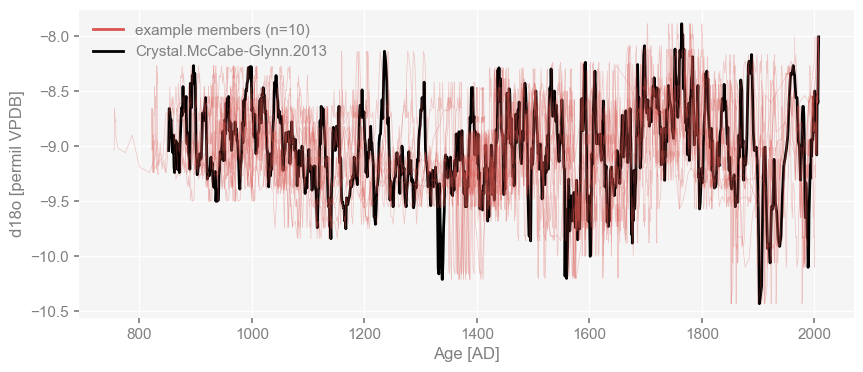

In [21]:
fig, ax = cc_ens.plot_traces(mute=True)
cc.plot(color='black', ax = ax)
pyleo.showfig(fig)

It is quite plain that any of the record's main swings can be swung back and forth by up to decades. Another way to see this is to plot various quantiles as an envelope:

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


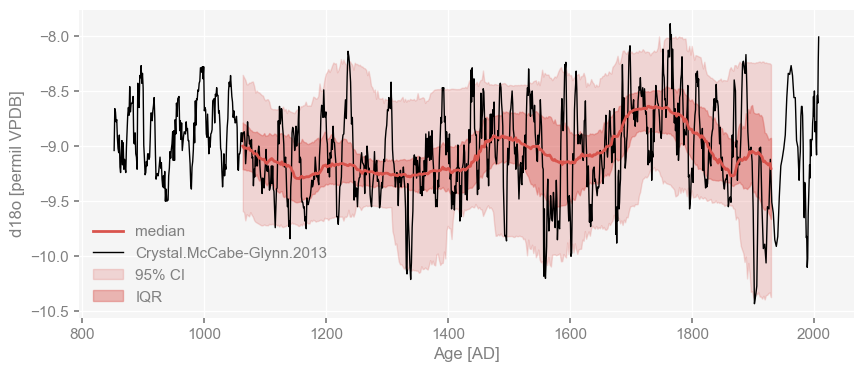

In [22]:
fig, ax = cc_ens.common_time(method='interp').plot_envelope(ylabel = cc.value_name, mute=True)
cc.plot(color='black', ax = ax, linewidth=1)
pyleo.showfig(fig)

Notice how the quantiles are computed over only part of the interval covered by the original series; that is because some age models end up being more compressed or stretched out than the original, and we need a common interval to compute quantiles. In particular, notice how the base of the record could really be anywhere between 850 and 1100 AD.

Now, what we'd like to do is repeat the exercise of Part 1, correlating the same SST timeseries from 32.5N 157.5W (near the Kuroshio Extension), not just with the published chronology, but this whole ensemble. Remember how we had computed things:

In [23]:
corr_res = stts.correlation(cc)
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.317461       0.14  False



Though of course, we could have done just the reverse, as correlation is a symmetric operator:

In [24]:
corr_res = cc.correlation(stts)
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.317461       0.15  False



Now, consider the task ahead: you must iterate over all ensemble members, taking care of aligning their time axis to that of HadSST4; you must compute the correlation and establish its significance with a sensible test (say, Ebisuzaki's isospectral test, see Pitfall #1), you need watch out for test multiplicity (see Pitfall #2) _and_  you need to visualize the results in an intuitive way. Don't you wish this has all been conveniently coded for you?



![Your wish](https://am23.mediaite.com/tms/cnt/uploads/2020/12/Life-Is-Good-but-It-Can-Be-Better-With-These-Max-Lord-Memes.jpg)


YOUR WISH HAS BEEN GRANTED!!!

To keep computing time manageable, let's reduce the number of isospectral simulations to 500, and correlate the ensemble and the SST series:

In [25]:
nsim = 500
corr_Kuroshio = cc_ens.correlation(stts,settings={'nsim':nsim}) 

  0%|                                          | 2/1000 [00:00<00:56, 17.62it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  1%|▎                                         | 6/1000 [00:00<00:58, 16.86it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  1%|▍                                        | 10/1000 [00:00<00:58, 16.86it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  1%|▌                                        | 14/1000 [00:00<00:56, 17.52it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  2%|▋                                        | 18/1000 [00:01<00:58, 16.84it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.

  2%|▉                                        | 22/1000 [00:01<00:56, 17.21it/s]


The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  3%|█                                        | 26/1000 [00:01<00:54, 17.98it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  3%|█▏                                       | 30/1000 [00:01<00:55, 17.40it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  3%|█▍                                       | 34/1000 [00:01<00:54, 17.86it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  4%|█▌                                       | 38/1000 [00:02<00:56, 16.91it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  4%|█▋                                       | 42/1000 [00:02<00:58, 16.46it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  5%|█▉                                       | 46/1000 [00:02<00:57, 16.49it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  5%|██                                       | 50/1000 [00:02<00:59, 16.05it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


  5%|██▏                                      | 52/1000 [00:03<00:56, 16.65it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  6%|██▎                                      | 56/1000 [00:03<00:56, 16.80it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  6%|██▌                                      | 62/1000 [00:03<00:51, 18.13it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  6%|██▌                                      | 64/1000 [00:03<00:53, 17.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  7%|██▊                                      | 68/1000 [00:03<00:53, 17.47it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  7%|███                                      | 74/1000 [00:04<00:50, 18.46it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


  8%|███▏                                     | 78/1000 [00:04<00:49, 18.68it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


  8%|███▎                                     | 80/1000 [00:04<00:50, 18.29it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  8%|███▍                                     | 85/1000 [00:04<00:49, 18.59it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  9%|███▋                                     | 89/1000 [00:05<00:49, 18.46it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


  9%|███▊                                     | 93/1000 [00:05<00:52, 17.33it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 10%|███▉                                     | 97/1000 [00:05<00:54, 16.64it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 10%|████                                    | 101/1000 [00:05<00:51, 17.45it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 10%|████                                    | 103/1000 [00:05<00:51, 17.56it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 11%|████▎                                   | 107/1000 [00:06<00:58, 15.37it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 11%|████▍                                   | 111/1000 [00:06<00:57, 15.47it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 12%|████▋                                   | 117/1000 [00:06<00:49, 17.89it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 12%|████▊                                   | 119/1000 [00:06<00:48, 17.99it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 12%|████▉                                   | 123/1000 [00:07<00:48, 17.91it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 13%|█████                                   | 128/1000 [00:07<00:47, 18.28it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 13%|█████▎                                  | 132/1000 [00:07<00:50, 17.36it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 14%|█████▍                                  | 136/1000 [00:07<00:48, 17.78it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 14%|█████▌                                  | 140/1000 [00:08<00:48, 17.71it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 14%|█████▋                                  | 142/1000 [00:08<00:48, 17.70it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 15%|█████▊                                  | 146/1000 [00:08<00:55, 15.32it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 15%|██████                                  | 150/1000 [00:08<00:54, 15.74it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 15%|██████▏                                 | 154/1000 [00:08<00:52, 16.05it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 16%|██████▎                                 | 158/1000 [00:09<00:50, 16.69it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 16%|██████▍                                 | 162/1000 [00:09<00:46, 17.89it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 17%|██████▋                                 | 166/1000 [00:09<00:46, 18.11it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 17%|██████▊                                 | 170/1000 [00:09<00:45, 18.23it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 17%|██████▉                                 | 174/1000 [00:10<00:46, 17.89it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 18%|███████                                 | 178/1000 [00:10<00:47, 17.40it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 18%|███████▎                                | 182/1000 [00:10<00:48, 16.87it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 18%|███████▎                                | 184/1000 [00:10<00:47, 17.03it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 19%|███████▌                                | 188/1000 [00:10<00:47, 16.96it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 19%|███████▋                                | 192/1000 [00:11<00:46, 17.24it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 20%|███████▊                                | 196/1000 [00:11<00:46, 17.32it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 20%|████████                                | 200/1000 [00:11<00:45, 17.66it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 20%|████████▏                               | 205/1000 [00:11<00:43, 18.23it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 21%|████████▎                               | 209/1000 [00:12<00:42, 18.68it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 21%|████████▌                               | 213/1000 [00:12<00:41, 18.84it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 22%|████████▋                               | 217/1000 [00:12<00:43, 18.07it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 22%|████████▊                               | 221/1000 [00:12<00:42, 18.51it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 22%|█████████                               | 225/1000 [00:12<00:42, 18.19it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 23%|█████████▏                              | 229/1000 [00:13<00:42, 17.97it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 23%|█████████▎                              | 233/1000 [00:13<00:40, 18.79it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 24%|█████████▍                              | 237/1000 [00:13<00:41, 18.50it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 24%|█████████▋                              | 241/1000 [00:13<00:42, 17.77it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 24%|█████████▊                              | 245/1000 [00:14<00:43, 17.42it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 25%|█████████▉                              | 249/1000 [00:14<00:43, 17.15it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 25%|██████████                              | 253/1000 [00:14<00:40, 18.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.

 26%|██████████▎                             | 257/1000 [00:14<00:40, 18.19it/s]


The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 26%|██████████▍                             | 261/1000 [00:14<00:43, 17.04it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 26%|██████████▌                             | 265/1000 [00:15<00:41, 17.72it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 27%|██████████▋                             | 267/1000 [00:15<00:41, 17.68it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 27%|██████████▉                             | 272/1000 [00:15<00:39, 18.24it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 28%|███████████                             | 276/1000 [00:15<00:39, 18.48it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 28%|███████████▏                            | 280/1000 [00:16<00:38, 18.61it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 29%|███████████▍                            | 286/1000 [00:16<00:37, 19.08it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 29%|███████████▌                            | 288/1000 [00:16<00:37, 19.22it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 29%|███████████▋                            | 292/1000 [00:16<00:38, 18.20it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 30%|███████████▊                            | 296/1000 [00:16<00:37, 18.70it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 30%|████████████                            | 301/1000 [00:17<00:36, 19.29it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 30%|████████████▏                           | 305/1000 [00:17<00:37, 18.74it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 31%|████████████▎                           | 309/1000 [00:17<00:37, 18.49it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 31%|████████████▌                           | 313/1000 [00:17<00:38, 17.70it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 32%|████████████▋                           | 317/1000 [00:18<00:39, 17.14it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 32%|████████████▊                           | 321/1000 [00:18<00:38, 17.72it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 32%|█████████████                           | 325/1000 [00:18<00:38, 17.69it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 33%|█████████████▏                          | 329/1000 [00:18<00:38, 17.54it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 33%|█████████████▎                          | 333/1000 [00:18<00:38, 17.16it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 34%|█████████████▍                          | 337/1000 [00:19<00:40, 16.37it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 34%|█████████████▌                          | 339/1000 [00:19<00:40, 16.52it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 34%|█████████████▋                          | 343/1000 [00:19<00:40, 16.32it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 35%|█████████████▉                          | 347/1000 [00:19<00:43, 15.17it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 35%|██████████████                          | 351/1000 [00:20<00:41, 15.77it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 36%|██████████████▏                         | 355/1000 [00:20<00:39, 16.48it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 36%|██████████████▎                         | 357/1000 [00:20<00:41, 15.65it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 36%|██████████████▍                         | 362/1000 [00:20<00:36, 17.43it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 37%|██████████████▋                         | 366/1000 [00:20<00:35, 17.68it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 37%|██████████████▊                         | 370/1000 [00:21<00:35, 17.57it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 37%|██████████████▉                         | 374/1000 [00:21<00:35, 17.53it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 38%|███████████████                         | 378/1000 [00:21<00:34, 17.92it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 38%|███████████████▎                        | 382/1000 [00:21<00:35, 17.44it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 39%|███████████████▍                        | 386/1000 [00:22<00:34, 17.70it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 39%|███████████████▌                        | 390/1000 [00:22<00:34, 17.90it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 39%|███████████████▊                        | 394/1000 [00:22<00:33, 17.96it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 40%|███████████████▉                        | 398/1000 [00:22<00:34, 17.38it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 40%|████████████████                        | 402/1000 [00:23<00:34, 17.14it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 41%|████████████████▏                       | 406/1000 [00:23<00:35, 16.83it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 41%|████████████████▍                       | 410/1000 [00:23<00:35, 16.41it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 41%|████████████████▌                       | 414/1000 [00:23<00:33, 17.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 42%|████████████████▋                       | 418/1000 [00:23<00:32, 17.75it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 42%|████████████████▉                       | 422/1000 [00:24<00:32, 18.05it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 43%|█████████████████                       | 426/1000 [00:24<00:31, 18.04it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 43%|█████████████████▏                      | 430/1000 [00:24<00:32, 17.44it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 43%|█████████████████▎                      | 434/1000 [00:24<00:33, 16.89it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 44%|█████████████████▌                      | 438/1000 [00:25<00:33, 16.54it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 44%|█████████████████▋                      | 442/1000 [00:25<00:32, 17.04it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 45%|█████████████████▊                      | 446/1000 [00:25<00:31, 17.69it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 45%|██████████████████                      | 450/1000 [00:25<00:31, 17.38it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 45%|██████████████████▏                     | 454/1000 [00:26<00:31, 17.13it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 46%|██████████████████▎                     | 458/1000 [00:26<00:32, 16.88it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 46%|██████████████████▍                     | 462/1000 [00:26<00:32, 16.73it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 47%|██████████████████▋                     | 466/1000 [00:26<00:31, 16.84it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 47%|██████████████████▊                     | 470/1000 [00:26<00:30, 17.43it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 47%|██████████████████▉                     | 474/1000 [00:27<00:31, 16.53it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 48%|███████████████████                     | 478/1000 [00:27<00:32, 16.05it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 48%|███████████████████▎                    | 482/1000 [00:27<00:31, 16.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 49%|███████████████████▍                    | 486/1000 [00:27<00:31, 16.47it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 49%|███████████████████▌                    | 490/1000 [00:28<00:31, 16.42it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 49%|███████████████████▊                    | 494/1000 [00:28<00:30, 16.37it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 50%|███████████████████▉                    | 498/1000 [00:28<00:32, 15.65it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 50%|████████████████████                    | 502/1000 [00:28<00:30, 16.33it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 51%|████████████████████▏                   | 506/1000 [00:29<00:29, 16.97it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 51%|████████████████████▍                   | 510/1000 [00:29<00:30, 16.25it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 51%|████████████████████▍                   | 512/1000 [00:29<00:31, 15.64it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 52%|████████████████████▋                   | 516/1000 [00:29<00:28, 16.72it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 52%|████████████████████▊                   | 520/1000 [00:30<00:28, 16.75it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 52%|████████████████████▉                   | 524/1000 [00:30<00:28, 16.55it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 53%|█████████████████████                   | 528/1000 [00:30<00:28, 16.85it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 53%|█████████████████████▎                  | 532/1000 [00:30<00:27, 16.83it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 54%|█████████████████████▍                  | 536/1000 [00:30<00:27, 16.68it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 54%|█████████████████████▌                  | 540/1000 [00:31<00:27, 16.87it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 54%|█████████████████████▊                  | 544/1000 [00:31<00:27, 16.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 55%|█████████████████████▉                  | 548/1000 [00:31<00:27, 16.73it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 55%|██████████████████████                  | 552/1000 [00:31<00:25, 17.34it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 56%|██████████████████████▏                 | 556/1000 [00:32<00:26, 16.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.

 56%|██████████████████████▍                 | 560/1000 [00:32<00:26, 16.42it/s]


The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 56%|██████████████████████▌                 | 564/1000 [00:32<00:25, 16.85it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 57%|██████████████████████▋                 | 568/1000 [00:32<00:26, 16.50it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 57%|██████████████████████▉                 | 572/1000 [00:33<00:24, 17.17it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 58%|███████████████████████                 | 576/1000 [00:33<00:24, 17.44it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 58%|███████████████████████▏                | 580/1000 [00:33<00:25, 16.38it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 58%|███████████████████████▎                | 584/1000 [00:33<00:24, 17.01it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 59%|███████████████████████▌                | 588/1000 [00:34<00:24, 16.74it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 59%|███████████████████████▋                | 592/1000 [00:34<00:23, 17.04it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 60%|███████████████████████▊                | 596/1000 [00:34<00:23, 17.52it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 60%|████████████████████████                | 600/1000 [00:34<00:22, 18.08it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 60%|████████████████████████▏               | 604/1000 [00:34<00:22, 17.52it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 61%|████████████████████████▎               | 608/1000 [00:35<00:21, 18.39it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 61%|████████████████████████▍               | 612/1000 [00:35<00:21, 17.65it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 62%|████████████████████████▋               | 616/1000 [00:35<00:21, 17.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 62%|████████████████████████▊               | 620/1000 [00:35<00:21, 17.42it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 62%|█████████████████████████               | 625/1000 [00:36<00:20, 18.37it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 63%|█████████████████████████               | 627/1000 [00:36<00:21, 17.51it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 63%|█████████████████████████▎              | 633/1000 [00:36<00:20, 17.86it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 64%|█████████████████████████▍              | 635/1000 [00:36<00:21, 17.19it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 64%|█████████████████████████▌              | 639/1000 [00:36<00:20, 17.49it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 64%|█████████████████████████▋              | 643/1000 [00:37<00:20, 17.24it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 65%|█████████████████████████▉              | 647/1000 [00:37<00:21, 16.52it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 65%|██████████████████████████              | 651/1000 [00:37<00:20, 16.87it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 66%|██████████████████████████▏             | 655/1000 [00:37<00:19, 17.36it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 66%|██████████████████████████▎             | 659/1000 [00:38<00:18, 18.14it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 66%|██████████████████████████▌             | 664/1000 [00:38<00:18, 18.30it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 67%|██████████████████████████▊             | 669/1000 [00:38<00:17, 19.28it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 67%|██████████████████████████▊             | 671/1000 [00:38<00:16, 19.43it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 68%|███████████████████████████             | 675/1000 [00:38<00:17, 19.10it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 68%|███████████████████████████▏            | 680/1000 [00:39<00:16, 19.20it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 68%|███████████████████████████▎            | 684/1000 [00:39<00:16, 18.80it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 69%|███████████████████████████▌            | 689/1000 [00:39<00:16, 18.86it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 69%|███████████████████████████▋            | 693/1000 [00:39<00:16, 18.23it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 70%|███████████████████████████▊            | 696/1000 [00:40<00:16, 18.98it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 70%|████████████████████████████            | 701/1000 [00:40<00:15, 18.94it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 70%|████████████████████████████▏           | 705/1000 [00:40<00:16, 17.79it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 71%|████████████████████████████▎           | 709/1000 [00:40<00:16, 17.51it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 71%|████████████████████████████▌           | 713/1000 [00:41<00:17, 16.37it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 72%|████████████████████████████▋           | 717/1000 [00:41<00:17, 16.40it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 72%|████████████████████████████▊           | 721/1000 [00:41<00:16, 16.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 72%|█████████████████████████████           | 725/1000 [00:41<00:16, 17.03it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 73%|█████████████████████████████▏          | 729/1000 [00:42<00:15, 17.21it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 73%|█████████████████████████████▎          | 733/1000 [00:42<00:15, 17.73it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 74%|█████████████████████████████▍          | 737/1000 [00:42<00:14, 17.63it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 74%|█████████████████████████████▋          | 741/1000 [00:42<00:14, 17.49it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 74%|█████████████████████████████▊          | 745/1000 [00:42<00:15, 16.20it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 75%|█████████████████████████████▉          | 749/1000 [00:43<00:15, 16.02it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 75%|██████████████████████████████          | 753/1000 [00:43<00:15, 16.22it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 76%|██████████████████████████████▎         | 757/1000 [00:43<00:14, 16.57it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 76%|██████████████████████████████▍         | 761/1000 [00:43<00:14, 16.89it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 76%|██████████████████████████████▌         | 765/1000 [00:44<00:15, 15.66it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 77%|██████████████████████████████▋         | 767/1000 [00:44<00:14, 16.07it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 77%|██████████████████████████████▊         | 771/1000 [00:44<00:14, 16.30it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 78%|███████████████████████████████         | 775/1000 [00:44<00:14, 15.03it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 78%|███████████████████████████████▏        | 779/1000 [00:45<00:13, 16.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 78%|███████████████████████████████▎        | 783/1000 [00:45<00:12, 17.17it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 79%|███████████████████████████████▍        | 787/1000 [00:45<00:12, 17.41it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 79%|███████████████████████████████▋        | 791/1000 [00:45<00:11, 17.81it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 80%|███████████████████████████████▊        | 795/1000 [00:45<00:11, 17.81it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 80%|███████████████████████████████▉        | 799/1000 [00:46<00:11, 16.92it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 80%|████████████████████████████████        | 803/1000 [00:46<00:11, 17.35it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 81%|████████████████████████████████▎       | 807/1000 [00:46<00:11, 17.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 81%|████████████████████████████████▎       | 809/1000 [00:46<00:11, 17.32it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 81%|████████████████████████████████▌       | 814/1000 [00:47<00:10, 18.33it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 82%|████████████████████████████████▋       | 818/1000 [00:47<00:10, 18.07it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 82%|████████████████████████████████▉       | 823/1000 [00:47<00:09, 18.75it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 83%|█████████████████████████████████       | 828/1000 [00:47<00:08, 19.34it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 83%|█████████████████████████████████▎      | 832/1000 [00:47<00:08, 19.07it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 84%|█████████████████████████████████▍      | 836/1000 [00:48<00:08, 18.99it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 84%|█████████████████████████████████▌      | 840/1000 [00:48<00:08, 18.99it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 84%|█████████████████████████████████▊      | 844/1000 [00:48<00:08, 19.14it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 85%|█████████████████████████████████▊      | 846/1000 [00:48<00:08, 18.97it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 85%|██████████████████████████████████      | 850/1000 [00:48<00:08, 18.47it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 85%|██████████████████████████████████▏     | 854/1000 [00:49<00:08, 17.81it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 86%|██████████████████████████████████▎     | 858/1000 [00:49<00:07, 18.10it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 86%|██████████████████████████████████▍     | 862/1000 [00:49<00:08, 16.97it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.

 87%|██████████████████████████████████▋     | 866/1000 [00:49<00:07, 17.28it/s]


The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 87%|██████████████████████████████████▊     | 870/1000 [00:50<00:07, 17.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 87%|██████████████████████████████████▉     | 874/1000 [00:50<00:07, 17.44it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 88%|███████████████████████████████████     | 878/1000 [00:50<00:07, 17.02it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 88%|███████████████████████████████████▎    | 882/1000 [00:50<00:06, 17.52it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 89%|███████████████████████████████████▍    | 886/1000 [00:51<00:06, 17.40it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 89%|███████████████████████████████████▌    | 890/1000 [00:51<00:06, 17.56it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 89%|███████████████████████████████████▊    | 894/1000 [00:51<00:06, 17.51it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 90%|███████████████████████████████████▉    | 898/1000 [00:51<00:05, 17.88it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 90%|████████████████████████████████████    | 902/1000 [00:51<00:05, 16.98it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 91%|████████████████████████████████████▏   | 906/1000 [00:52<00:05, 16.86it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 91%|████████████████████████████████████▍   | 910/1000 [00:52<00:05, 17.23it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 91%|████████████████████████████████████▌   | 914/1000 [00:52<00:05, 16.33it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 92%|████████████████████████████████████▋   | 916/1000 [00:52<00:05, 16.39it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 92%|████████████████████████████████████▊   | 920/1000 [00:53<00:04, 16.45it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 92%|████████████████████████████████████▉   | 924/1000 [00:53<00:04, 16.74it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 93%|█████████████████████████████████████   | 928/1000 [00:53<00:04, 16.98it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 93%|█████████████████████████████████████▎  | 932/1000 [00:53<00:03, 17.76it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 94%|█████████████████████████████████████▍  | 936/1000 [00:53<00:03, 17.61it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 94%|█████████████████████████████████████▌  | 940/1000 [00:54<00:03, 18.01it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde


 94%|█████████████████████████████████████▊  | 945/1000 [00:54<00:03, 17.27it/s]

Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 95%|█████████████████████████████████████▉  | 949/1000 [00:54<00:02, 17.94it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 95%|██████████████████████████████████████  | 953/1000 [00:54<00:02, 17.48it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 96%|██████████████████████████████████████▎ | 957/1000 [00:55<00:02, 17.01it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 96%|██████████████████████████████████████▍ | 961/1000 [00:55<00:02, 17.36it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 96%|██████████████████████████████████████▌ | 965/1000 [00:55<00:01, 17.78it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 97%|██████████████████████████████████████▊ | 969/1000 [00:55<00:01, 18.27it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 97%|██████████████████████████████████████▉ | 973/1000 [00:56<00:01, 18.62it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 98%|███████████████████████████████████████ | 977/1000 [00:56<00:01, 17.67it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 98%|███████████████████████████████████████▏| 981/1000 [00:56<00:01, 17.65it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 98%|███████████████████████████████████████▍| 985/1000 [00:56<00:00, 17.34it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 99%|███████████████████████████████████████▌| 989/1000 [00:56<00:00, 17.70it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


 99%|███████████████████████████████████████▋| 993/1000 [00:57<00:00, 17.66it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


100%|███████████████████████████████████████▉| 997/1000 [00:57<00:00, 17.60it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.36it/s]

The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.
The time axis has been adjusted to be prograde
Duplicate timestamps have been combined by averaging values.


Now here's the best part: the `corr_Kuroshio` is an object that contains everything you want: the vector of correlations, the p-values, _and_ a method to plot them all:

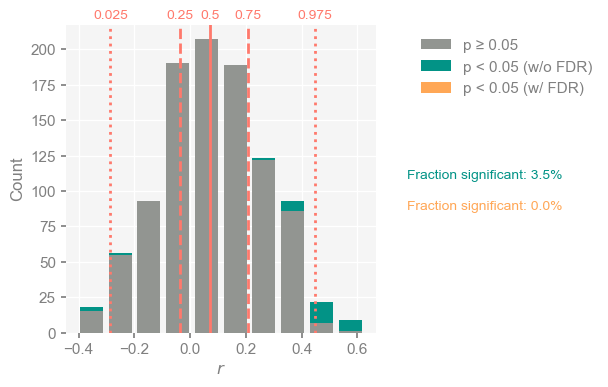

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

In [26]:
corr_Kuroshio.plot()

Several things jump out at once:
1. the correlation histogram is relatively symmetric, meaning that age uncertainties are able to completely overturn the original correlation of about 0.27 : nearly half of the ensemble exhibits negative correlations with SST).  0.27 was exactly a contender for winning the correlation olympics, but it was at least positive.
1. As shown in green, only 7\% of the 500*100 correlations just computed are judged significant (note: this would change somewhat every time you run the calculation, based on the randomness of the phase randomization procedure. If reproducibility is essential, you  may also input a [random seed](https://en.wikipedia.org/wiki/Random_seed) to ensure that the same exact random sequence is used from iteration to iteration. 
1. Once we take test multiplicity into account via the False Discovery Rate (orange bar), only 0.3%  of the correlations are deemed significant. 

**Exercise 5.4** redo this at other locations and see if the results change. you may consider picking a patch of the North Pacific and applying this test recursively at each location. 

In [ ]:
## your code here ##

## Conclusions


**Exercise 5.5**  To bring it all together, summarize everything that can go wrong when fishing for correlations (at sea, or on land). Can you think of other papers where correlations with paleoclimate records might have been used unwisely to buttress interpretation? 

**Answer 5.5** YOUR WORDS HERE